In [2]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import glob
from nilearn.image import resample_img
import skimage.transform as skTrans

import nibabel as nib
import cv2
import imageio
from tqdm.notebook import tqdm
from ipywidgets import *
from PIL import Image
import fastai; fastai.__version__
from fastai.basics import *
from fastai.vision.all import *
from fastai.data.transforms import *

c:\Users\Justine Huang\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\detection\anchor_utils.py:63: UserWarning: Failed to initialize NumPy: module compiled against API version 0x10 but this version of numpy is 0xf (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:68.)
  device: torch.device = torch.device("cpu"),


In [3]:
# Create a meta file for nii files processing

file_list = []    

for dirname, _, filenames in os.walk('D:\liver-tumor-segmentation'):
    for filename in filenames:
        file_list.append((dirname,filename)) 

df_files = pd.DataFrame(file_list, columns =['dirname', 'filename']) 
df_files.sort_values(by=['filename'], ascending=True)    

,dirname,filename
0,D:\liver-tumor-segmentation\segmentations,segmentation-0.nii
1,D:\liver-tumor-segmentation\segmentations,segmentation-1.nii
2,D:\liver-tumor-segmentation\segmentations,segmentation-10.nii
3,D:\liver-tumor-segmentation\segmentations,segmentation-100.nii
4,D:\liver-tumor-segmentation\segmentations,segmentation-101.nii
...,...,...
181,D:\liver-tumor-segmentation\volume_pt5,volume-50.nii
138,D:\liver-tumor-segmentation\volume_pt1,volume-6.nii
139,D:\liver-tumor-segmentation\volume_pt1,volume-7.nii
140,D:\liver-tumor-segmentation\volume_pt1,volume-8.nii


In [4]:
def read_nii(filepath):
    '''
    Reads .nii file and returns pixel array
    '''
    ct_scan = nib.load(filepath)
    array   = ct_scan.get_fdata()
    # array   = np.array(array)
    array   = np.rot90(np.array(array))
    return(array)

In [5]:
# Map CT scan and label 
df_files["mask_dirname"] = "" ; df_files["mask_filename"] = ""

for i in range(131):
    ct = f"volume-{i}.nii"
    mask = f"segmentation-{i}.nii"
    
    df_files.loc[df_files['filename'] == ct, 'mask_filename'] = mask
    df_files.loc[df_files['filename'] == ct, 'mask_dirname'] = "D:\liver-tumor-segmentation\segmentations"

df_files_test= df_files[df_files.mask_filename=='']
# drop segment rows
df_files = df_files[df_files.mask_filename != ''].sort_values(by=['filename']).reset_index(drop=True) 
print(len(df_files))

51
                                   dirname       filename  \
0   D:\liver-tumor-segmentation\volume_pt1   volume-0.nii   
1   D:\liver-tumor-segmentation\volume_pt1   volume-1.nii   
2   D:\liver-tumor-segmentation\volume_pt1  volume-10.nii   
3   D:\liver-tumor-segmentation\volume_pt2  volume-11.nii   
4   D:\liver-tumor-segmentation\volume_pt2  volume-12.nii   
5   D:\liver-tumor-segmentation\volume_pt2  volume-13.nii   
6   D:\liver-tumor-segmentation\volume_pt2  volume-14.nii   
7   D:\liver-tumor-segmentation\volume_pt2  volume-15.nii   
8   D:\liver-tumor-segmentation\volume_pt2  volume-16.nii   
9   D:\liver-tumor-segmentation\volume_pt2  volume-17.nii   
10  D:\liver-tumor-segmentation\volume_pt2  volume-18.nii   
11  D:\liver-tumor-segmentation\volume_pt2  volume-19.nii   
12  D:\liver-tumor-segmentation\volume_pt1   volume-2.nii   
13  D:\liver-tumor-segmentation\volume_pt2  volume-20.nii   
14  D:\liver-tumor-segmentation\volume_pt3  volume-21.nii   
15  D:\liver-tumor-se

In [1]:
#read sample
sample = 50
sample_ct   = read_nii(df_files.loc[sample,'dirname']+"/"+df_files.loc[sample,'filename'])
# downsampled_ct = resample_img(sample_ct, target_affine=np.eye(3)*2., interpolation='nearest')
sample_mask  = read_nii(df_files.loc[sample,'mask_dirname']+"/"+df_files.loc[sample,'mask_filename'])
# downsampled_mask = resample_img(sample_mask, target_affine=np.eye(3)*2., interpolation='nearest')
print(sample_ct.shape) 
print(sample_mask.shape)
print(df_files.loc[sample,'dirname']+"\"+df_files.loc[sample,'filename'])

SyntaxError: unterminated string literal (detected at line 9) (3099949305.py, line 9)

In [7]:
print(np.amin(sample_ct), np.amax(sample_ct))
print(np.amin(sample_mask), np.amax(sample_mask))

-1024.0 1651.0
0.0 2.0


In [ ]:
dicom_windows = types.SimpleNamespace(
    brain=(80,40),
    subdural=(254,100),
    stroke=(8,32),
    brain_bone=(2800,600),
    brain_soft=(375,40),
    lungs=(1500,-600),
    mediastinum=(350,50),
    abdomen_soft=(400,50),
    liver=(150,30),
    spine_soft=(250,50),
    spine_bone=(1800,400),
    custom = (200,60)
)

In [12]:
def plot_sample(array_list, color_map = 'nipy_spectral'):
    '''
    Plots and a slice with all available annotations
    '''
    fig = plt.figure(figsize=(18,15))

    plt.subplot(1,4,1)
    plt.imshow(array_list[0], cmap='bone')
    plt.title('Original Image')
    
    # plt.subplot(1,4,2)
    # plt.imshow(tensor(array_list[0].astype(np.float32)).windowed(*dicom_windows.liver), cmap='bone');
    # plt.title('Windowed Image')
    
    plt.subplot(1,4,3)
    plt.imshow(array_list[1], alpha=0.5, cmap=color_map)
    plt.title('Mask')
    
    plt.subplot(1,4,4)
    plt.imshow(array_list[0], cmap='bone')
    plt.imshow(array_list[1], alpha=0.5, cmap=color_map)
    plt.title('Liver & Mask')


    plt.show()

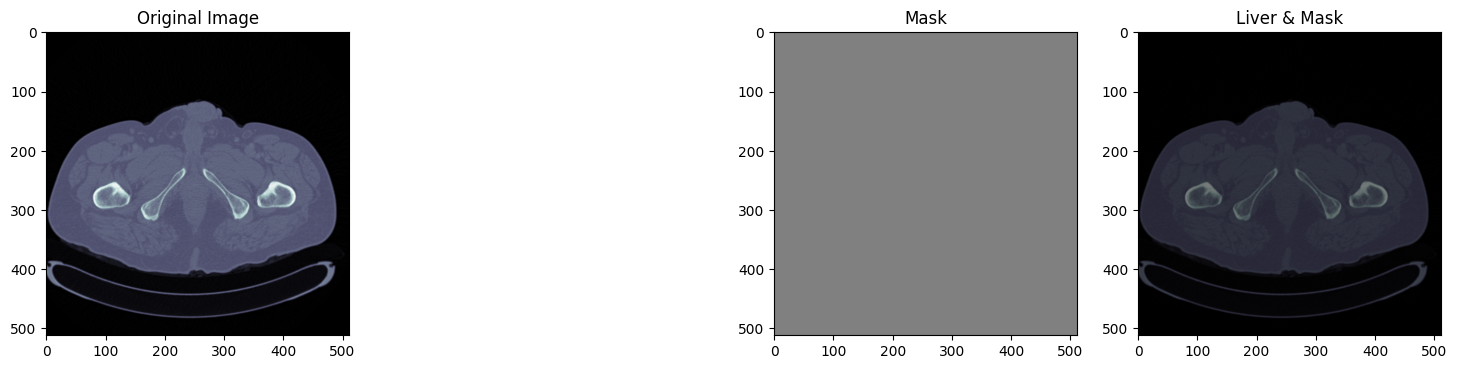

In [16]:
sample=50
sample_slice = sample_ct[...,sample]

# plot_sample([sample_ct[...,sample]])
plot_sample([sample_ct[...,sample], sample_mask[...,sample]])